#Forecasting Temperature in Greenland
by Steven Newton

---

![greenland](https://ichef.bbci.co.uk/news/976/cpsprodpb/11E93/production/_108336337_mediaitem108336330.jpg)

##Overview

The **Berkeley Earth Surface Temperature Study** combines 1.6 billion temperature reports from 16 archives. Berkeley publishes the source data and the code for the transformations applied.

Several files are included in [the Kaggle dataset](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data). For this brief project, I will be using mean monthly temperatures recorded in Greenland between 1823 and 2013.

The raw data, without transformations, comes from the [Berkeley Earth data page](http://berkeleyearth.org/data/).

##Summary

Greenland is the coldest country on earth with a national average temperature of -19 degrees Celsius since 1823. Historically, winters average -30 deg. Cel. and summers average -3 deg. Cel. producing a very pronounced seasonality in temperature cycles. Although Greenland has experienced brief warming trends, most notably in the current century, I do not notice enough of a long-term trend to include it in my forecasts. The best model was SARIMA (Seasonal AutoRegressive Integrated Moving Average) with an average error of 2.8 deg. Cel. on monthly mean temperature predictions. 

##Outline
* Data
  * Dictionary
  * Split
* Exploration
  * Visualizing mean temps by month
  * Simple and moving averages
  * Autocorrelation and lag plots
  * Seasonal decomposition
* Modeling
  * Simple and moving averages
  * Previous cycle
  * ARIMA/SARIMA
  * Forecasts through 2030

In [1]:
import warnings
warnings.simplefilter("ignore")

import pandas as pd
from datetime import timedelta, datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')

##Data dictionary

* *AverageTemperature*: global average land temperature in celsius (target variable)
* *AverageTemperatureUncertainty*: the 95% confidence interval around the average 

In [2]:
#Greenland temperatures taken from GlobalLandTemperaturesByCountry.csv
PATH = '/content/drive/MyDrive/Colab Notebooks/data/'

df = pd.read_csv(PATH+'GreenlandLandTemperatures.csv')
df = df.set_index('dt')
df.index = pd.to_datetime(df.index)
df = df.rename(columns={'AverageTemperature':'temp',
                        'AverageTemperatureUncertainty':'ci'})
df = df.iloc[:-1] #last row is missing data

season_dict = {0:'winter', 1:'spring', 2:'summer', 3:'fall'}
season_idx = df.index.month % 12 // 3
df['season'] = season_idx.map(season_dict)

print(df.head(2))
print(df.tail(2))
print('\n')
df.info()

              temp     ci  season
dt                               
1823-01-01 -29.921  3.768  winter
1823-02-01 -32.374  3.495  winter
             temp     ci  season
dt                              
2013-07-01 -1.292  1.046  summer
2013-08-01 -4.221  0.859  summer


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2288 entries, 1823-01-01 to 2013-08-01
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    2288 non-null   float64
 1   ci      2288 non-null   float64
 2   season  2288 non-null   object 
dtypes: float64(2), object(1)
memory usage: 71.5+ KB


Annual temps reveal a warming period begun in the 1980s. Readings also become significantly more accurate over time as indicated by a tighter confidence interval. This increased accuracy is due in part to the switch from mercury to electronic thermometers. Incidentally, these same thermometers have a "cold bias" according to Berkeley, which their researchers account for by adding a bias term to later readings.

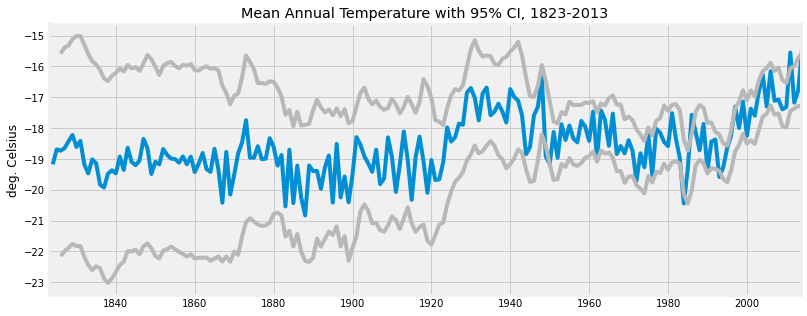

In [31]:
annual = df.resample('Y').mean()
f, ax = plt.subplots(figsize=(12,5))

sns.lineplot(data=annual.temp)
#plot confidence intervals with moving average
upper = (annual.temp+annual.ci).rolling(3).mean()
lower = (annual.temp-annual.ci).rolling(3).mean()
sns.lineplot(data=upper, color='#b8b8b8')
sns.lineplot(data=lower, color='#b8b8b8')

plt.title('Mean Annual Temperature with 95% CI, 1823-2013')
plt.ylabel('deg. Celsius')
plt.xlabel('')
plt.xlim(df.index[0], df.index[-1])
plt.show()

##Split data
Train 1823-1995

Test 1996-2013

The test set has rising temperatures.

In [4]:
begin_test = 1996

test = df[df.index.year >= begin_test]
train = df[df.index.year < begin_test]
train.shape, test.shape

((2076, 3), (212, 3))

Here is a close-up of the seasonal cycle during Abraham Lincoln's presidency. The cycle bottoms out in January and tops out in July, like all the rest of the Northern Hemisphere. It looks just like a sine wave. 

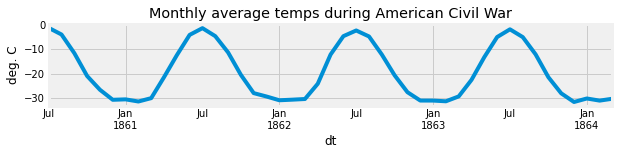

In [5]:
train.temp.iloc[450:495].plot(title='Monthly average temps during American Civil War',
                              ylabel="deg. C", figsize=(9,1.5));


##Exploration

In [6]:
train.describe()

,temp,ci
count,2076.000000,2076.000000
mean,-18.746606,1.932375
std,10.883740,1.018567
min,-37.658000,0.364000
25%,-28.738250,1.074750
50%,-21.397000,1.701000
75%,-8.133250,2.861000
max,0.233000,8.425000


dt
1    -30.810844
2    -30.857890
3    -29.092266
4    -22.625538
5    -12.178208
6     -4.668064
7     -1.770590
8     -4.425850
9    -11.658075
10   -20.415665
11   -26.570306
12   -29.885983
Name: temp, dtype: float64


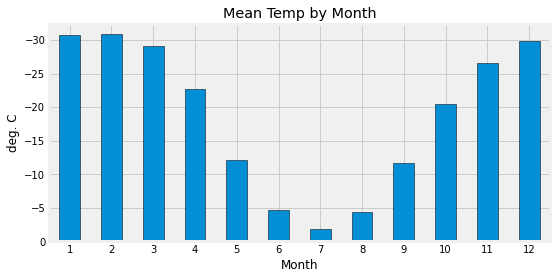

In [148]:
monthly_means = train.temp.groupby(train.index.month).mean()
ax = monthly_means.plot.bar(width=.5, figsize=(8,4), ec='black')
plt.xticks(rotation=0)
ax.invert_yaxis()
ax.set(title='Mean Temp by Month', xlabel='Month', ylabel='deg. C')
print(monthly_means)
plt.show()

* Greenland is cold! The mean temperature is below freezing in all but three months between 1823 and 1953. It turns out this data is reporting temperatures many degrees too low according to Greenland's main travel site, even when considering only the coldest, northern towns like Upernavik. Here are the mean monthly temps reported by the government of Greenland.

![temps](https://i.ibb.co/tMzMNwx/Screen-Shot-2021-10-10-at-1-43-49-AM.png)

Or maybe the government doesn't want tourists to know how cold there country is!


* I also notice four modes at -30 deg., -21 deg., -13 deg, and -5 deg., which I thought may represent the four seasons. Instead, the two extreme groups represent summer and winter while the middle two are a blend of fall and spring.
* The overall mean of the training data is -18.8 deg. I'll take it with a grain of salt but since the temps appear to be low across the board, time series modeling may not be affected. (Note that an averages of averages of subsets is the average of the whole set if the subsets are all the same sample size; 12 in this case.)

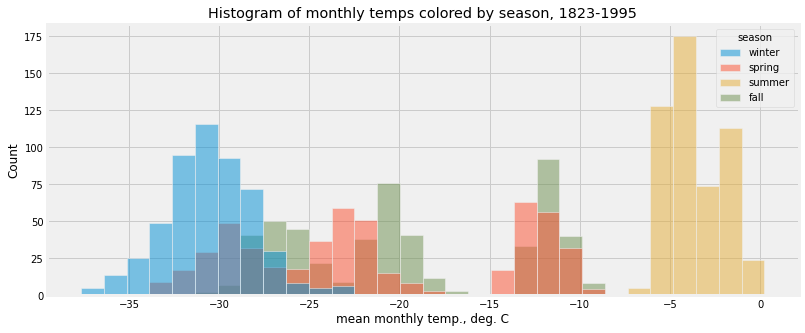

In [8]:
plt.figure(figsize=(12,5))
sns.histplot(data=train, x='temp', bins=30, hue='season')
plt.xlabel('mean monthly temp., deg. C')
plt.title('Histogram of monthly temps colored by season, 1823-1995')
plt.show()

Winters appear to have more variability than Summers.

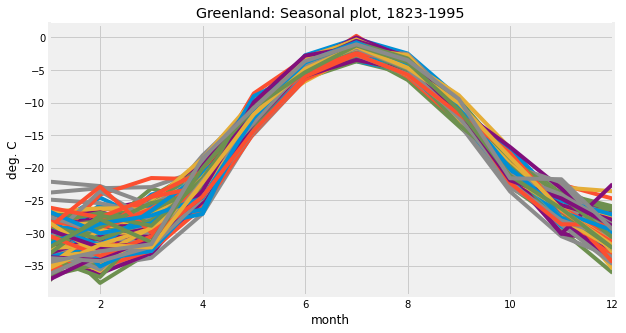

In [9]:
train.temp.groupby([train.index.year,
                    train.index.month]).mean().unstack(0).plot(figsize=(9,5))
plt.title('Greenland: Seasonal plot, 1823-1995')
plt.xlabel('month')
plt.ylabel('deg. C')
plt.xlim(1,12)
plt.legend().remove()

Let's look at simple and moving averages. The biggest change is 1925-1935, as seen in the plot of temperature changes per 5-year periods.

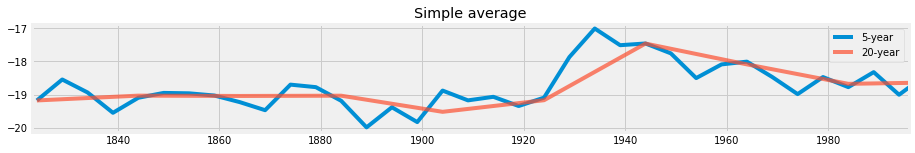

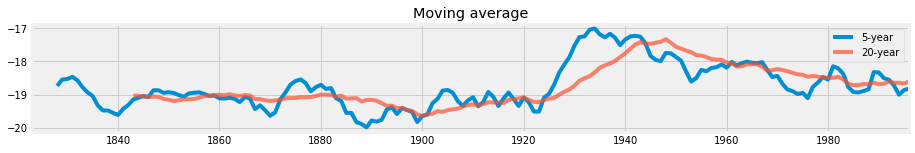

In [10]:
f, ax = plt.subplots(figsize=(14,2))
ax.plot(train.temp.resample('5Y').mean(), label='5-year')
ax.plot(train.temp.resample('20Y').mean(), alpha=.7, label='20-year')

plt.title('Simple average')
plt.xlim(train.index[0], train.index[-1])

plt.legend()
plt.show()

f, ax = plt.subplots(figsize=(14,2))
ax.plot(train.temp.resample('Y').mean().rolling(5).mean(), label='5-year')
ax.plot(train.temp.resample('Y').mean().rolling(20).mean(), alpha=.7, label='20-year')

plt.title('Moving average')
plt.xlim(train.index[0], train.index[-1])

plt.legend()
plt.show()

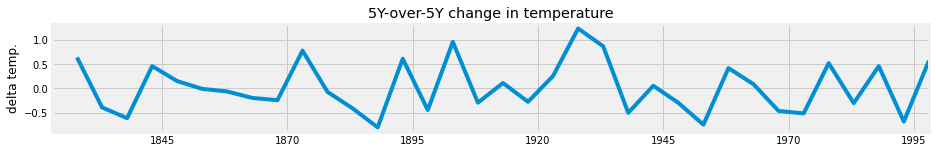

In [32]:
diff = train.temp.resample('5Y').mean().diff()
diff.plot(title='5Y-over-5Y change in temperature', xlabel='', ylabel='delta temp.', figsize=(14,2));

###Autocorrelation, 1923-1927

More ways to visualize seasonality. Self-correlation is near 1 at 1-year intervals and near -1 at 6-month intervals.

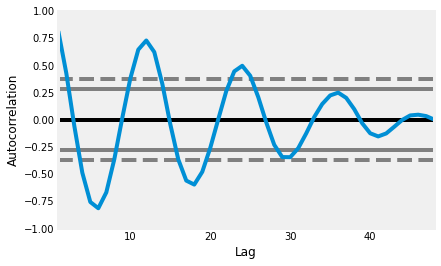

In [12]:
pd.plotting.autocorrelation_plot(train.temp.iloc[1200:1248].resample('M').mean());

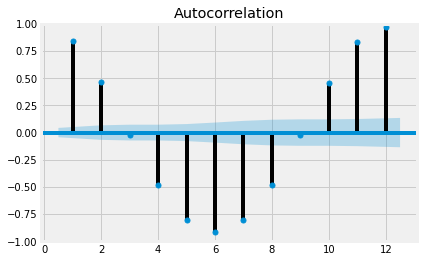

In [13]:
fig, ax1 = plt.subplots()
# Plot the ACF on ax1, lag can be greater than period but not less than
plot_acf(train.temp, lags=12, zero=False, ax=ax1);

###Lag plot

At lag 1 and 2, the months diverge evenly in both directions and form 9-10 visible clusters. At lag 6, the relatioship is negative linear (warm becomes cold and cold becomes warm) with 5 clusters. At lag 12 (month-over-month) the relationship is positive linear, with greater dispersion at colder temperatures.

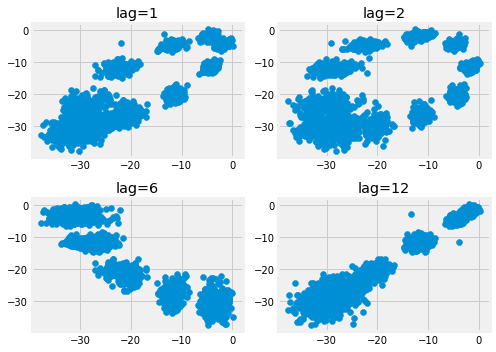

In [14]:
f, ax = plt.subplots(2,2, figsize=(7,5))

ax[0,0].scatter(train.temp, train.temp.shift(-1))
ax[0,0].set_title('lag=1')
ax[0,1].scatter(train.temp, train.temp.shift(-2))
ax[0,1].set_title('lag=2')
ax[1,0].scatter(train.temp, train.temp.shift(-6))
ax[1,0].set_title('lag=6')
ax[1,1].scatter(train.temp, train.temp.shift(-12))
ax[1,1].set_title('lag=12')
plt.tight_layout();

###Seasonal Decomposition, 1923-1931

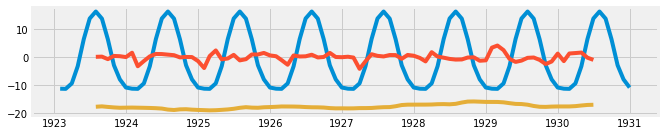

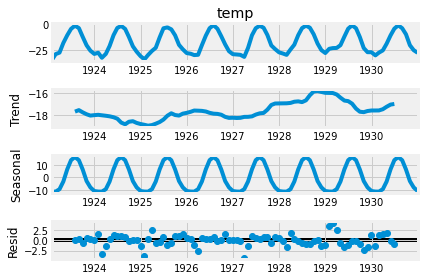

In [15]:
result = seasonal_decompose(train.temp.iloc[1200:1296].resample('M').mean())

f, ax = plt.subplots(figsize=(10,2))
ax.plot(result.seasonal)
ax.plot(result.resid)
ax.plot(result.trend)
plt.show()

result.plot()
plt.show()

Over the whole training set, there isn't an obvious trend. Long-term, I think it is **trend stationary** but the time series dispalys obvious **seasonality**, which should be modeled and removed them from observations, with the models trained on the residuals.

##Model

I've made many lovely charts but the purpose of this project is to predict future temperatures in Greenland.

###Moving average

MA(1) is a first-order moving average model. The method is suitable for univariate time series without trend and seasonal components.

In [16]:
#first a simple average
print(f'\nRMSE for temp, simple average: {mean_squared_error(test.temp,\
                          np.zeros((len(test),))+train.temp.mean(), squared=False)}')
#then a moving average
rmses = []
for p in range(1, 366):  
  pred = np.zeros((len(test),)) + train.temp.rolling(p).mean().iloc[-1]
  rmses.append(mean_squared_error(test.temp, pred, squared=False))

print(f'Best temp moving average: {1+np.argmin(rmses)}-day, RMSE {min(rmses)}')


RMSE for temp, simple average: 10.533774769947936
Best temp moving average: 5-day, RMSE 10.393549874575243


###Previous cycle

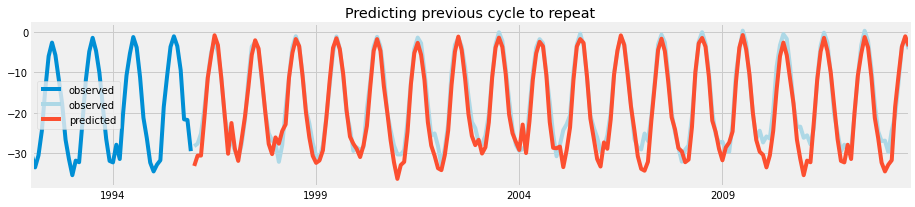

RMSE for temp, delta YOY: 2.899304239081286


In [146]:
start_idx = 12-len(test)%12

#cycle = list(train.temp.iloc[-12:])
#cycle_repeated = np.array(len(cycle * (len(test)//12) + cycle[:len(test)%12]))

cycle_pred = train.temp.iloc[-(len(test)+start_idx):-start_idx]
cycle_pred.index = test.index

plt.figure(figsize=(14,3))
train.temp[-48:].plot()
test.temp.plot(color='lightblue')
cycle_pred.plot()
plt.title('Predicting previous cycle to repeat')
plt.legend(['observed','observed','predicted'])
plt.xlabel('')
plt.show()
  
print(f'RMSE for temp, delta YOY: {mean_squared_error(test.temp, cycle_pred, squared=False)}')

###ARIMA/SARIMA

We know there is a strong seasonal component and that there are no exogenrpus variable to include so SARIMA will probably be the best model.

- Seasonal ARIMA = SARIMA
$$ \text{SARIMA}(p, d, q)(P, D, Q)_S $$
    - Non-seasonal orders
        - p: autoregressive order
        - d: differencing order
        - q: moving average order
    - Seasonal orders
        - P: seasonal autoregressive order
        - D: seasonal differencing order
        - Q: seasonal moving average order
        - S: Number of time steps per cycle
- The SARIMA model
    - ARIMA(2, 0, 1) model:
$$ y_t = a_1 y_{t-1} + a_2 y_{t-2} + m_1 \epsilon_{t-1} + \epsilon_t $$
    - SARIMA(0,0,0)(2, 0, 1, 12) model:
$$ y_t = a_7 y_{t-7} + a_{14} y_{t-14} + m_y \epsilon_{t-7} + \epsilon_t $$

- Seasonal differencing
    - Subtract the time series value of one season ago
$$ \Delta y_t = y_t - y_{t-S} $$

In [75]:
## Create ARIMA model (not seasonal)
model = SARIMAX(train.temp, order=(3, 1, 2), trend='c')
arima_results = model.fit()

# Create SARIMAX model
model = SARIMAX(train.temp, order=(1, 0, 2), seasonal_order=(2, 1, 0, 12))
sarima_results = model.fit()
sarima_results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:599: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:599: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/usr/local

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                temp   No. Observations:                 2076
Model:             SARIMAX(1, 0, 2)x(2, 1, [], 12)   Log Likelihood               -4050.390
Date:                             Sun, 10 Oct 2021   AIC                           8112.780
Time:                                     05:00:14   BIC                           8146.574
Sample:                                          0   HQIC                          8125.169
                                            - 2076                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6923      0.137      5.044      0.000       0.423       0.961
ma.L1         -0.4216      0.138     -3.047      0.002      -0.693      -0.150
ma.L2         -0.0971      0.049     -1.976      0.048      -0.193      -0.001
ar.S.L12      -0.6477      0.014    -46.627      0.000      -0.675      -0.621
ar.S.L24      -0.3455      0.014    -25.239      0.000      -0.372      -0.319
sigma2         2.9561      0.056     52.331      0.000       2.845       3.067
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1001.22
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.09   Skew:                             0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)



RMSE ARIMA: 7.593387559631637

RMSE SARIMA: 2.787532884605935


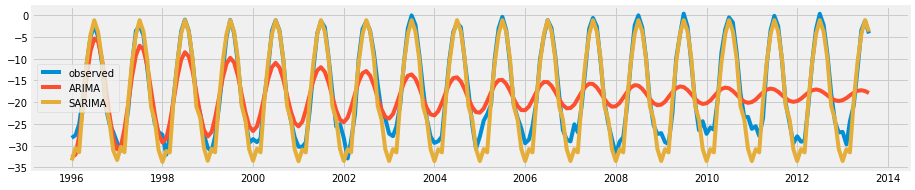

In [76]:
dates = test.index

# Create ARIMA/SARIMA mean forecast
arima_pred = arima_results.get_forecast(len(dates))
sarima_pred = sarima_results.get_forecast(len(dates))

arima_mean = arima_pred.predicted_mean
sarima_mean = sarima_pred.predicted_mean

print(f'\nRMSE ARIMA: {mean_squared_error(test.temp,\
                          arima_mean, squared=False)}')

print(f'\nRMSE SARIMA: {mean_squared_error(test.temp,\
                          sarima_mean, squared=False)}')

# Plot mean ARIMA and SARIMA predictions and observed
plt.figure(figsize=(14,3))
plt.plot(test.temp, label='observed');
plt.plot(dates, arima_mean, label='ARIMA');
plt.plot(dates, sarima_mean, label='SARIMA');
plt.legend();

The best model is SARIMA followed closely by simple predicting the last cycle to repeat itself.

In [125]:
model_rmses = {'Simple average': 10.5,
               '5-day moving average': 10.4,
               'Last cycle': 2.90,
               'ARIMA': 7.59,
               'SARIMA': 2.79}
pd.DataFrame(data=model_rmses.values(), index=model_rmses.keys(), columns=['RMSE (deg. C)'])

,RMSE (deg. C)
Simple average,10.50
5-day moving average,10.40
Last cycle,2.90
ARIMA,7.59
SARIMA,2.79


##Forecast to 2030

The forecasts aren't too exciting: an annual cycle to repeat ad infinitum.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:599: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:599: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/usr/local

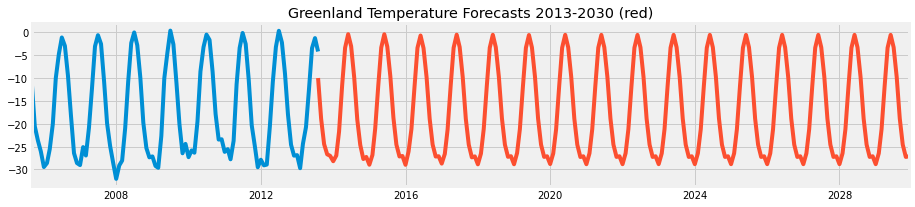

In [88]:
dates = pd.date_range(df.index[-1], '2030-01-01' , freq='1M')-pd.offsets.MonthBegin(1)

model = SARIMAX(df.temp, order=(1,0,2), seasonal_order=(2,1,0,12))
sarima_results = model.fit()

sarima_pred = sarima_results.get_forecast(len(dates))
sarima_mean = sarima_pred.predicted_mean

plt.figure(figsize=(14,3))
plt.plot(test.index[-m:], test.temp[-m:], label='observed');
plt.plot(dates, sarima_mean, label='predictions');
plt.xlim(test.index[-m], dates[-1])
plt.title('Greenland Temperature Forecasts 2013-2030 (red)');

That's all folks!